Обучим с помощью нейросети mobilenet_v2 на датасете Flowers102 из torchvision модель, способную классифицировать арктический ареал обитания цветка на изображении или нет

Ссылка на Колаб https://colab.research.google.com/drive/1d9U9y0ZbR8yHvhSk7A_SKeIWm44YDJUb?usp=sharing

Добавим импорты

In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import scipy

from PIL import Image
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.utils import make_grid
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, roc_auc_score

Скачаем датасет и проведем его предварительную обработку: аугментации, нормализация согласно MobileNetV2. Используем те же параметры нормализации что и в MobileNetV2, так как будем использовать предобученную модель

In [ ]:
data_root = "data"

# аугментации, нормализация согласно MobileNetV2 (предобучалась на таких настройках)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# скачиваем датасет из torchvision с трансформациями и разбитием на train, val, test
train_set = Flowers102(root=data_root, split="train",
                       transform=train_transform, download=True)
val_set   = Flowers102(root=data_root, split="val",
                       transform=test_transform, download=True)
test_set  = Flowers102(root=data_root, split="test",
                       transform=test_transform, download=True)

Выведем все категории и обнаружим среди них те, что относятся к арктическим помощью ЛЛМ

In [6]:
for idx, name in enumerate[str](train_set.classes):
    print(idx+1, name)

1 pink primrose
2 hard-leaved pocket orchid
3 canterbury bells
4 sweet pea
5 english marigold
6 tiger lily
7 moon orchid
8 bird of paradise
9 monkshood
10 globe thistle
11 snapdragon
12 colt's foot
13 king protea
14 spear thistle
15 yellow iris
16 globe-flower
17 purple coneflower
18 peruvian lily
19 balloon flower
20 giant white arum lily
21 fire lily
22 pincushion flower
23 fritillary
24 red ginger
25 grape hyacinth
26 corn poppy
27 prince of wales feathers
28 stemless gentian
29 artichoke
30 sweet william
31 carnation
32 garden phlox
33 love in the mist
34 mexican aster
35 alpine sea holly
36 ruby-lipped cattleya
37 cape flower
38 great masterwort
39 siam tulip
40 lenten rose
41 barbeton daisy
42 daffodil
43 sword lily
44 poinsettia
45 bolero deep blue
46 wallflower
47 marigold
48 buttercup
49 oxeye daisy
50 common dandelion
51 petunia
52 wild pansy
53 primula
54 sunflower
55 pelargonium
56 bishop of llandaff
57 gaura
58 geranium
59 orange dahlia
60 pink-yellow dahlia?
61 cautleya s

После анализа с ЛЛМ категорий выше, пришли к выводу, что под описание арктические подходят следующие категории: 48, 49, 50, 53, 67. Отобразим по 4 примера изображений из этих категорий, чтобы иметь представление как они выглядят

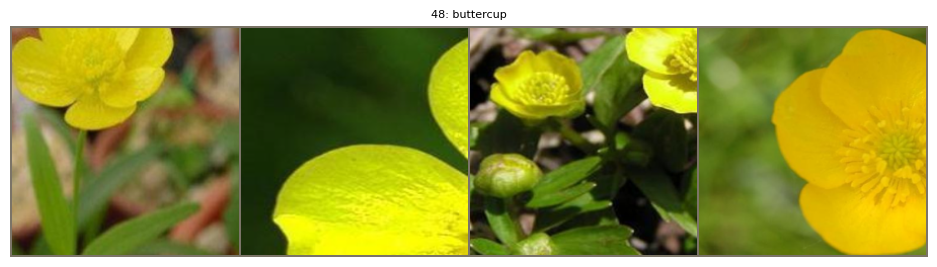

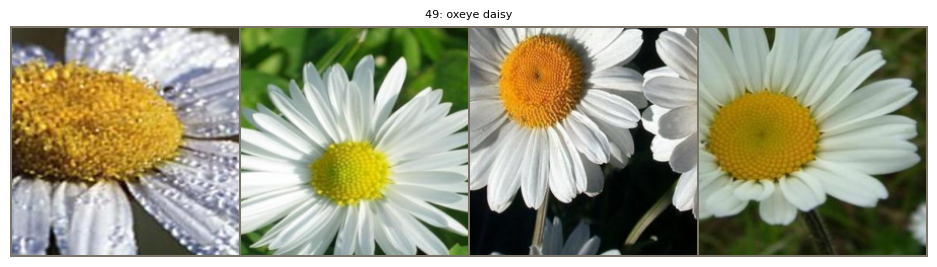

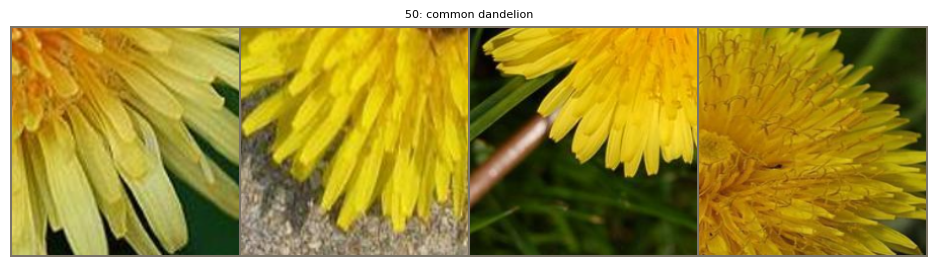

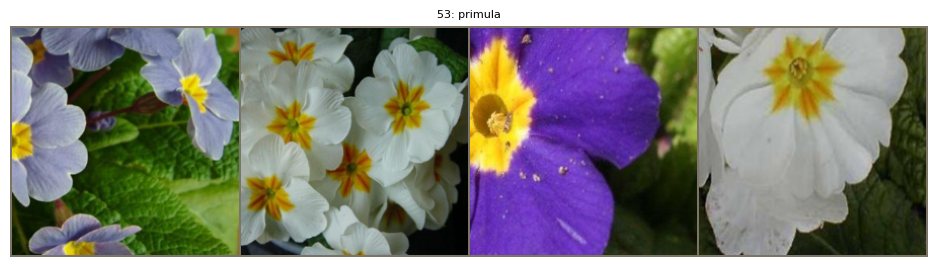

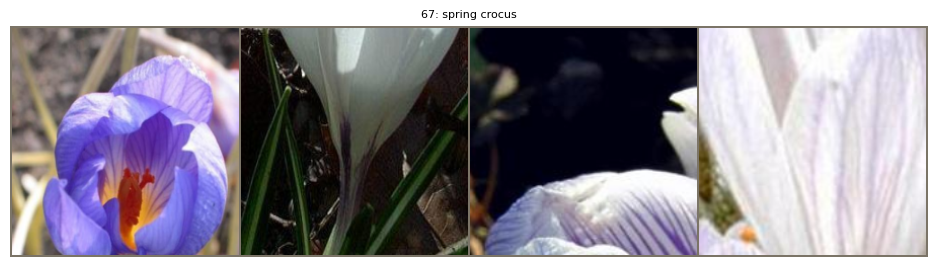

In [9]:
ARCTIC_CLASSES = {48, 49, 50, 53, 67}

N = 4 # Сколько картинок показывать для каждого класса

examples = {cls: [] for cls in ARCTIC_CLASSES}
labels = {cls: train_set.classes[cls-1] for cls in ARCTIC_CLASSES}

for img, label in train_set:
    cls = label + 1
    
    if cls in ARCTIC_CLASSES and len(examples[cls]) < N:
        examples[cls].append(img)

    if all(len(v) >= N for v in examples.values()):
        break

for cls in sorted(ARCTIC_CLASSES):
    imgs = examples[cls]
    lbl = labels[cls]

    grid = make_grid(torch.stack(imgs), nrow=N)

    # денормализация
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    grid = grid * std + mean
    grid = grid.clamp(0, 1)

    plt.figure(figsize=(12, 3))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"{cls}: {lbl}", fontsize=8)
    plt.axis("off")
    plt.show()

 Имея в наличии информацию об арктических категориях, можем написать враппер для датасета, который будет проводить бинарную классификацию: арктический цветок или нет. В связи с несбалансированностью датасета проведем сэмплирование в сторону уравнивания выборок 

In [13]:

class ArcticWrapper(Dataset):
    def __init__(self, base_ds):
        self.ds = base_ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]
        label_1to102 = label + 1
        binary = 1 if label_1to102 in ARCTIC_CLASSES else 0 # 1 - арктический, 0 - не арктический
        return img, torch.tensor(binary, dtype=torch.float32)

train_arctic = ArcticWrapper(train_set)
val_arctic = ArcticWrapper(val_set)
test_arctic = ArcticWrapper(test_set)

all_labels = []
for _, y in train_arctic:
    all_labels.append(int(y.item()))

labels_tensor = torch.tensor(all_labels, dtype=torch.long)

# Считаем, сколько объектов каждого класса
class_counts = torch.bincount(labels_tensor)
print("class_counts:", class_counts)

# Вес классов: реже встречающийся класс получает больший вес
class_weights = 1.0 / class_counts.float()
print("class_weights:", class_weights)

# Веса для каждого сэмпла в датасете
sample_weights = class_weights[labels_tensor]  # shape = (N,)

# Самплер, который будет выбирать примеры пропорционально sample_weights
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),   # сколько сэмплов на эпоху
    replacement=True                   # с возвращением (oversampling)
)

train_loader = DataLoader(train_arctic, batch_size=32, sampler=sampler, shuffle=False)
val_loader   = DataLoader(val_arctic, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_arctic, batch_size=32, shuffle=False)


class_counts: tensor([970,  50])
class_weights: tensor([0.0010, 0.0200])


Локально на Макбуке используем mps, в Колабе или на Windows можно cuda

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

Дообучим модель, за основу возьмем готовую, чтобы избежать длительного обучения. В качестве лосс возьмем бинарную кросс-энтропию с логитом (т.к. классификация бинарная). На последнем слое будет один нейрон

In [100]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Создаем новый классификатор на последнем слое из одного нейрона
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)
model.to(device)

pos_weight = torch.tensor([1.0], device=device)  # не используем доп. вес, т.к. было оверсемплирование
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

# Количество эпох
num_epochs = 20

for epoch in range(num_epochs):
    # ------- TRAIN -------
    model.train()
    running_loss = 0.0
    train_labels = []
    train_probs = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        probs = torch.sigmoid(outputs)
        # Сохраняем метки и вероятности для ROC-AUC
        train_labels.extend(labels.detach().cpu().numpy().flatten())
        train_probs.extend(probs.detach().cpu().numpy().flatten())

    # Вычисляем ROC-AUC для train (лучше показывает результат для несбалансированных данных чем accuracy)
    train_labels = np.array(train_labels)
    train_probs = np.array(train_probs)
    train_roc_auc = roc_auc_score(train_labels, train_probs)

    # ------- VALIDATION -------
    model.eval()
    val_loss = 0.0
    val_labels = []
    val_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            # Сохраняем метки и вероятности для ROC-AUC
            val_labels.extend(labels.detach().cpu().numpy().flatten())
            val_probs.extend(probs.detach().cpu().numpy().flatten())

    val_loss = val_loss / len(val_labels)
    
    # Вычисляем ROC-AUC для validation
    val_labels = np.array(val_labels)
    val_probs = np.array(val_probs)
    val_roc_auc = roc_auc_score(val_labels, val_probs)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train ROC-AUC: {train_roc_auc:.4f} | Val Loss: {val_loss:.4f} | Val ROC-AUC: {val_roc_auc:.4f}"
    )

Epoch [1/20] Train ROC-AUC: 0.4732 | Val Loss: 0.6591 | Val ROC-AUC: 0.5785
Epoch [2/20] Train ROC-AUC: 0.5412 | Val Loss: 0.6577 | Val ROC-AUC: 0.6415
Epoch [3/20] Train ROC-AUC: 0.5910 | Val Loss: 0.6717 | Val ROC-AUC: 0.6920
Epoch [4/20] Train ROC-AUC: 0.6599 | Val Loss: 0.6662 | Val ROC-AUC: 0.7537
Epoch [5/20] Train ROC-AUC: 0.6958 | Val Loss: 0.6605 | Val ROC-AUC: 0.7826
Epoch [6/20] Train ROC-AUC: 0.7344 | Val Loss: 0.6546 | Val ROC-AUC: 0.8062
Epoch [7/20] Train ROC-AUC: 0.7663 | Val Loss: 0.6452 | Val ROC-AUC: 0.8278
Epoch [8/20] Train ROC-AUC: 0.7887 | Val Loss: 0.6487 | Val ROC-AUC: 0.8417
Epoch [9/20] Train ROC-AUC: 0.8232 | Val Loss: 0.6455 | Val ROC-AUC: 0.8593
Epoch [10/20] Train ROC-AUC: 0.8219 | Val Loss: 0.6317 | Val ROC-AUC: 0.8696
Epoch [11/20] Train ROC-AUC: 0.8390 | Val Loss: 0.6270 | Val ROC-AUC: 0.8777
Epoch [12/20] Train ROC-AUC: 0.8551 | Val Loss: 0.6187 | Val ROC-AUC: 0.8828
Epoch [13/20] Train ROC-AUC: 0.8660 | Val Loss: 0.6066 | Val ROC-AUC: 0.8928
Epoch [1

Сохраним модель, чтобы не проводить обучение каждый раз

In [109]:
torch.save(model.state_dict(), "model/model.pth")

Чтобы использовать без обучения, пропускаем предыдущий шаг с обучением и сохранением и выполняем следующий

In [ ]:
model = models.mobilenet_v2(weights=None)
model.classifier[1] = nn.Linear(model.last_channel, 1)
model.load_state_dict(torch.load("model/model.pth", map_location=device))
model.to(device)
model.eval()

Объявим CLASSIFICATION_THRESHOLD = 0.5 (по умолчанию). 
Это порог классификации: вероятность выше которой модель предсказывает класс ARCTIC

In [102]:
CLASSIFICATION_THRESHOLD = 0.5

Реализуем методы для выполнения модели на тестовых данных и инференса на одном изображении

In [ ]:
def evaluate(model, loader, device):
    model.eval()

    all_labels_result = []
    all_preds_result = []
    all_probs_result = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)

            if logits.ndim == 2 and logits.shape[1] == 1:
                logits = logits.squeeze(1)

            probs = torch.sigmoid(logits)
            preds = (probs >= CLASSIFICATION_THRESHOLD).float()

            all_labels_result.extend(labels.cpu().numpy())
            all_preds_result.extend(preds.cpu().numpy())
            all_probs_result.extend(probs.cpu().numpy())

    return all_labels_result, all_probs_result, all_preds_result

def predict_image(model, image_path, device):
    model.eval()

    img = Image.open(image_path).convert("RGB")
    img_t = test_transform(img).unsqueeze(0).to(device) # выполняем нормализацию как на тестовой выборке

    with torch.no_grad():
        logits = model(img_t)

        if logits.ndim == 2:
            logits = logits.squeeze(1)

        prob = torch.sigmoid(logits).item()  # вероятность класса ARCTIC
        pred = 1 if prob >= CLASSIFICATION_THRESHOLD else 0

    label = "ARCTIC" if pred == 1 else "NON_ARCTIC"
    return label, prob

Протестируем обученную модель

In [103]:
all_labels_result, all_probs_result, all_preds_result = evaluate(model, test_loader, device)

Выведем метрики, посчитаем оптимальный threshold с помощью индекса Юдена

TEST: Acc=0.8125 Prec=0.1599
Rec=0.8623 F1=0.2698 ROCAUC=0.9051
Optimal Threshold ROC (Jodan Index)=0.5097


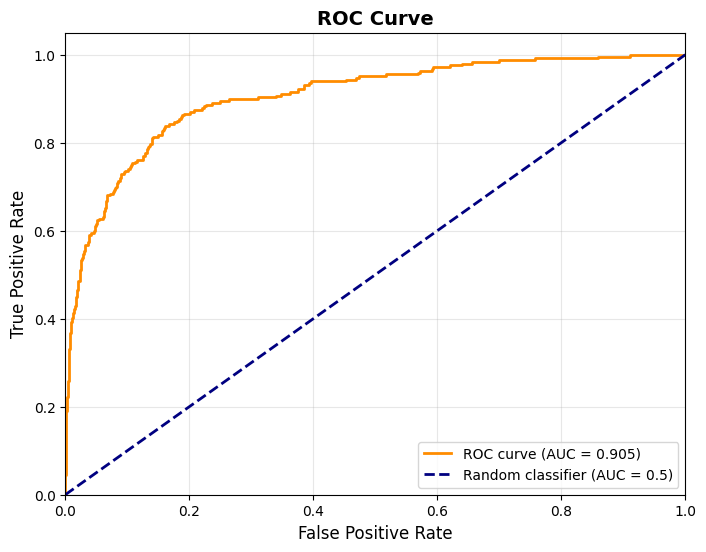

In [104]:
acc  = accuracy_score(all_labels_result, all_preds_result)
prec = precision_score(all_labels_result, all_preds_result, zero_division=0)
rec  = recall_score(all_labels_result, all_preds_result, zero_division=0)
f1   = f1_score(all_labels_result, all_preds_result, zero_division=0)

# ROC кривая
fpr, tpr, roc_thresholds = roc_curve(all_labels_result, all_probs_result)
roc_auc = auc(fpr, tpr)

# Находим оптимальный порог из ROC (индекс Юдена)
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = roc_thresholds[optimal_idx]

print(f"TEST: Acc={acc:.4f} Prec={prec:.4f}")
print(f"Rec={rec:.4f} F1={f1:.4f} ROCAUC={roc_auc:.4f}")
print(f"Optimal Threshold ROC (Jodan Index)={optimal_threshold:.4f}")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
            label='Random classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)

plt.show()

Что означают метрики:

1. Accuracy = 81%
Доля правильных предсказаний
Интерпретация: модель правильно предсказывает ≈81% примеров. Не информативный показатель для несбалансированных данных

1. Precision = 16%
Доля истинных ARCTIC среди предсказанных ARCTIC
Интерпретация: из всех предсказанных ARCTIC только ≈16% действительно ARCTIC; много ложных срабатываний. Объяснимо крайне несбалансированными классами. Плохой показатель precision норма для несбалансированных оверсемплированных данных

1. Recall = 86%
Доля найденных ARCTIC среди всех реальных ARCTIC
Интерпретация: модель находит ≈86% всех ARCTIC

1. F1-score = 27%
Гармоническое среднее Precision и Recall
Интерпретация: низкий F1 из-за несбалансированных классов. Много ложных срабатываний. Можно изменить CLASSIFICATION_THRESHOLD в сторону увеличения, чтобы уменьшить ложные срабатывания, но тогда потеряем способность находить ARCTIC

1. ROC_AUC = 91%
Площадь под ROC-кривой
Хороший показатель для несбалансированных классов. Не учитывает дизбаланс. Оценивает спобосность модели разделять классы

На основе рекомендованного, переобъявим CLASSIFICATION_THRESHOLD и пересчитаем F1, precision и recall

In [105]:
CLASSIFICATION_THRESHOLD = 0.51

In [106]:
all_labels_result, all_probs_result, all_preds_result = evaluate(model, test_loader, device)

In [107]:
acc  = accuracy_score(all_labels_result, all_preds_result)
prec = precision_score(all_labels_result, all_preds_result, zero_division=0)
rec  = recall_score(all_labels_result, all_preds_result, zero_division=0)
f1   = f1_score(all_labels_result, all_preds_result, zero_division=0)

print(f"TEST optimal threshold: Acc={acc:.4f} Prec={prec:.4f}")
print(f"Rec={rec:.4f} F1={f1:.4f}")

TEST optimal threshold: Acc=0.8393 Prec=0.1787
Rec=0.8340 F1=0.2943


Как видим, метрика F1 подросла, precision увеличился (уменьшилось количество ложных срабатываний), но уменьшился recall. Ожидаемое поведение. Повышая порог классификации, мы повышаем специфичность, но снижаем чувствительность модели. С помощью этого параметра можно провести финальную настройку модели в зависимости от приоритетов задачи

Проверим модель на отдельных изображениях

In [108]:
image_path_dandelion = "test/dandelion.jpg"
image_path_oxeye_daisy = "test/oxeye_daisy.jpg"
image_path_rose = "test/rose.jpg"

label_dandelion, probability_dandelion = predict_image(model, image_path_dandelion, device)
label_oxeye_daisy, probability_oxeye_daisy = predict_image(model, image_path_oxeye_daisy, device)
label_rose, probability_rose = predict_image(model, image_path_rose, device)

print(f"Dandelion Prediction: {label_dandelion}. Probability Arctic = {probability_dandelion:.4f}")
print(f"Oxeye Daisy Prediction: {label_oxeye_daisy}. Probability Arctic = {probability_oxeye_daisy:.4f}")
print(f"Rose Prediction: {label_rose}. Probability Arctic = {probability_rose:.4f}")

Dandelion Prediction: ARCTIC. Probability Arctic = 0.6588
Oxeye Daisy Prediction: ARCTIC. Probability Arctic = 0.6331
Rose Prediction: NON_ARCTIC. Probability Arctic = 0.3368


На практике как можем убедиться модель справляется с обнаружением ромашки и одуванчика (до созревания) и корректно относит их к арктическим цветам, а розу - к не арктическим